### Why

We want to accelarate and stablizes the training in the neural network. We do not want it to be dependent on carefully tuned initial weights and/or learning rates. The batch normalization provides a way to achieve this. The main problem that batch normalization solves for the neural network is reducing the `internal covariate shift`. 

> The problem of covariate shift occurs when the predictors (covariate) in the testing datasets come from a different distribution than the training dataset. Specifically,
$$
P_{\text{training}} (X) \neq P_{\text{testing}} (X)
$$
We train the model to minimize the error on training distirbution so it tries to minimize the error where the data is more dense in training distribution while the testing data could be dense into some other place consequently error in the testing dataset will be high.

**The problem of covariate shift can cause slow learning in neural network.**
In neural network, we usually do batch training using stochastic gradient descent (SGD). The parameters of network changes from one batch to the next batch. Consequently, the distribution of input that goes to a layer from its previous layer also changes. Consequently, neural network will keep finding different directions of update in different batch, and can take long time to converge.

Moreover, when we uses saturating unit such as sigmoid or tanh, they can get saturated due to internal covariate shift and can slow down the learning. The optimal gradient direction found for the present batch can cause the parameters to change such that because of covariate shift the next batch output could fall in the saturating regime of tanh and sigmoid activation function. 

### What

The batch normalization provides a way to alevate the internal covariate shift by normalizing the input that goes into a layer. Essentially, if a layer receives a input batch $\{x_i\}_{i=1}^m$, during batch normalization, this input will be shifted to have mean $0$, and scaled to have variance $1$. Mathematically,  
$$
\begin{array}{ccc}
\mu_b &=& \sum_{i=1}^m \frac{x_i}{m}\\
\sigma_b^2 &=& \sum_{i=1}^m \frac{1}{m}\left(x_i - \mu_b\right)^2\\
y_i &=& \gamma_t  \frac{(x_i - \mu_b)}{\sqrt{(\sigma_b^2 + \epsilon)}} + \beta_t
\end{array}
$$


### How

This simple thing of normalizing the input, makes sure that the input goes to a layer will have mean $0$ and variance $1$ on expectation thus reduces the problem internal covariate shift. Usually `Batch Normalization` is applied to the input of a non-linear function in neural net. The reason in author words is as following:
>  We add the BN transform immediately before the nonlinearity, by normalizing 
$ x = Wu+b$. We could have also normalized the layer inputs $u$,  but since $u$ is likely the output of another nonlinearity, the shape of its distribution is likely to change during training, and constraining its first and second moments would not eliminate the covariate shift.  In contrast, $Wu + b$ is more likely to have
a symmetric, non-sparse distribution, that is “more Gaussian”; normalizing it is likely to produce activations with a stable distribution.

1. ** Batch-norm as regularizer: ** Since each training example is seen in conjuction with other examples in a batch, the output of the network for a training example is not deterministic and this acts as a regularizer for the network.

2. ** Batch-norm for Conv Net: ** There will be only one $\gamma$ and $\beta$ parameters for each feature map.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
from time import time
from scipy.signal import savgol_filter

In [2]:
mnist = input_data.read_data_sets("MNIST", one_hot=True)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


### Intializer

In [3]:
batch_size = 64
learning_rate = 0.001
eps = 1e-8

In [4]:
# placehplder for inputs and targets
x = tf.placeholder(tf.float32, [None, 784], "images")
y_ = tf.placeholder(tf.int64, [None, 10], "labels")

In [5]:
# initializers
w1 = np.random.normal(size=(784,100), scale=1 / 28).astype(np.float32)
w2 = np.random.normal(size=(100,100), scale=0.1).astype(np.float32)
w3 = np.random.normal(size=(100,10), scale=0.1).astype(np.float32)

In [6]:
# Parameters for model without batch normalization
W1 = tf.Variable(w1)
b1 = tf.zeros(100)

W2 = tf.Variable(w2)
b2 = tf.zeros(100)

W3 = tf.Variable(w3)
b3 = tf.zeros(10)

In [7]:
# Parameters for model with batch normalization
W1_bn = tf.Variable(w1)
gamma_1, beta_1 = tf.Variable(tf.ones(100), ()), tf.Variable(tf.zeros(100), ())

W2_bn = tf.Variable(w2)
gamma_2, beta_2 = tf.Variable(tf.ones(100), ()), tf.Variable(tf.zeros(100), ())

W3_bn = tf.Variable(w3)
b3_bn = tf.zeros(10)

In [8]:
# the graph for model without batch normalization
z1 = tf.matmul(x, W1) + b1
a1 = tf.nn.sigmoid(z1)
z2 = tf.matmul(z1, W2) + b2
a2 = tf.nn.sigmoid(z2)
z3 = tf.matmul(a2, W3) + b3

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(z3, y_))

prob = tf.nn.softmax(z3)
y = tf.argmax(prob, dimension=1)
correct = tf.reduce_mean(tf.cast(tf.equal(y, tf.argmax(y_, 1)), tf.float32))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

In [9]:
# the graph for model with batch normalization
z1_bn = tf.matmul(x, W1_bn)

mu_1, sigma_1 = tf.nn.moments(z1_bn, axes=[0])
y1_bn = gamma_1 * (z1_bn - mu_1) / tf.sqrt(sigma_1 + eps) + beta_1

a1_bn = tf.nn.sigmoid(y1_bn)

z2_bn = tf.matmul(a1_bn, W2_bn)

mu_2, sigma_2 = tf.nn.moments(z2_bn, axes=[0])
y2_bn = tf.nn.batch_normalization(z2_bn, mu_2, sigma_2, beta_2, gamma_2, eps)

a2_bn = tf.nn.sigmoid(y2_bn)

z3_bn = tf.matmul(a2_bn, W3_bn) + b3_bn

loss_bn = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(z3_bn, y_))

prob_bn = tf.nn.softmax(z3_bn)
y_bn = tf.argmax(prob_bn, dimension=1)
correct_bn = tf.reduce_mean(tf.cast(tf.equal(y_bn, tf.argmax(y_, 1)), tf.float32))

optimizer_bn = tf.train.GradientDescentOptimizer(learning_rate)
train_step_bn = optimizer.minimize(loss_bn)

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [11]:
tic = time()
train_acc, train_acc_bn = [], []
train_losses, train_losses_bn = [], []
test_acc, test_acc_bn = [], []
test_losses, test_losses_bn = [], []
final_layers, final_layers_bn = [], []
for i in range(10000):
    images, labels = mnist.train.next_batch(batch_size)
    feed = {x: images, y_: labels}
    ops = [train_step, train_step_bn, loss, loss_bn, correct, correct_bn]
    _, _, train_loss, train_loss_bn, acc, acc_bn = sess.run(ops, feed)
    train_losses.append(train_loss) 
    train_losses_bn.append(train_loss_bn)
    train_acc.append(acc)
    train_acc_bn.append(acc_bn)
    if (i % 50) == 0:
        ops = [loss, loss_bn, correct, correct_bn, z3, z3_bn]
        test_loss, test_loss_bn, acc, acc_bn, final_layer, final_layer_bn = sess.run(ops,
                                               {x: mnist.test.images, y_: mnist.test.labels})
        final_layers.append(np.mean(final_layer, axis=0))
        final_layers_bn.append(np.mean(final_layer_bn, axis=0))
        test_losses.append(test_loss) 
        test_losses_bn.append(test_loss_bn)
        test_acc.append(acc)
        test_acc_bn.append(acc_bn)
print("time for run : {0:0.2f} seconds".format(time() - tic))

time for run : 69.60 seconds


### plotting 

In [12]:
def smooth(x):
    """
    apply savgol filtering to input
    """
    return savgol_filter(x, 51, 2)

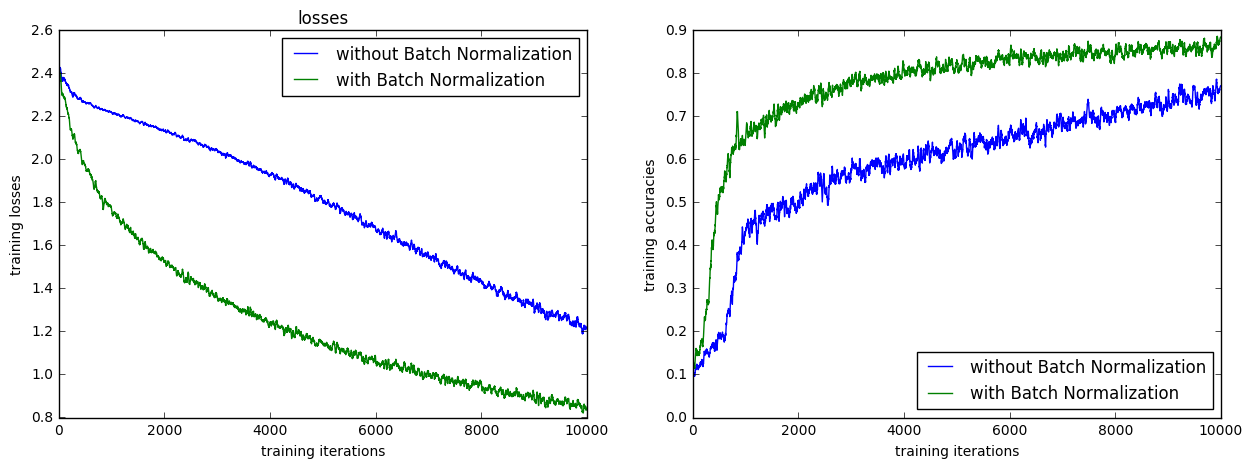

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(smooth(train_losses), label="without Batch Normalization")
plt.plot(smooth(train_losses_bn), label="with Batch Normalization")
plt.xlabel("training iterations")
plt.ylabel("training losses")
plt.title("losses")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(smooth(train_acc), label="without Batch Normalization")
plt.plot(smooth(train_acc_bn), label="with Batch Normalization")
plt.xlabel("training iterations")
plt.ylabel("training accuracies")
plt.legend(loc="lower right")

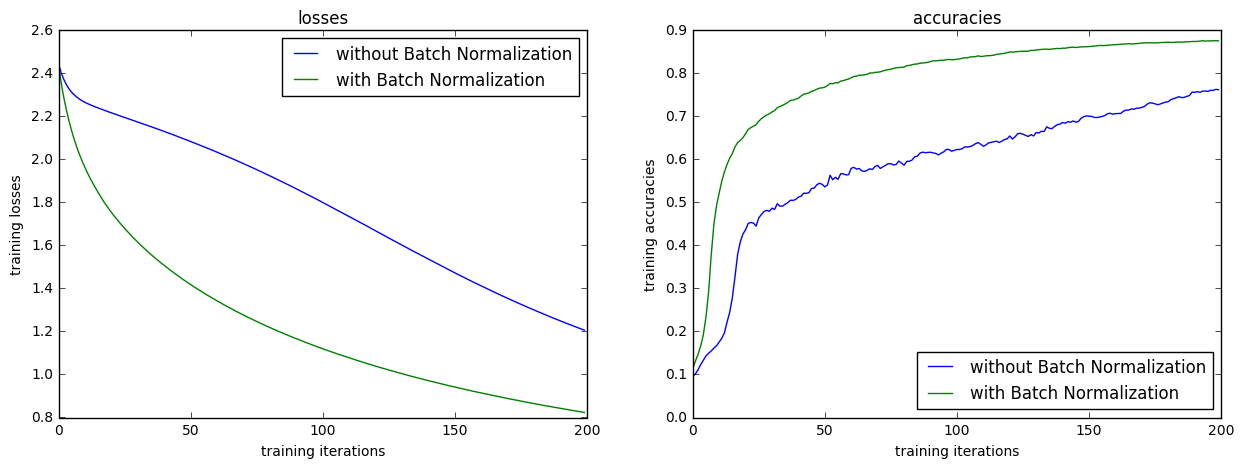

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label="without Batch Normalization")
plt.plot((test_losses_bn), label="with Batch Normalization")
plt.xlabel("training iterations")
plt.ylabel("training losses")
plt.title("losses")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot((test_acc), label="without Batch Normalization")
plt.plot((test_acc_bn), label="with Batch Normalization")
plt.xlabel("training iterations")
plt.ylabel("training accuracies")
plt.legend(loc="lower right")
plt.title("accuracies")

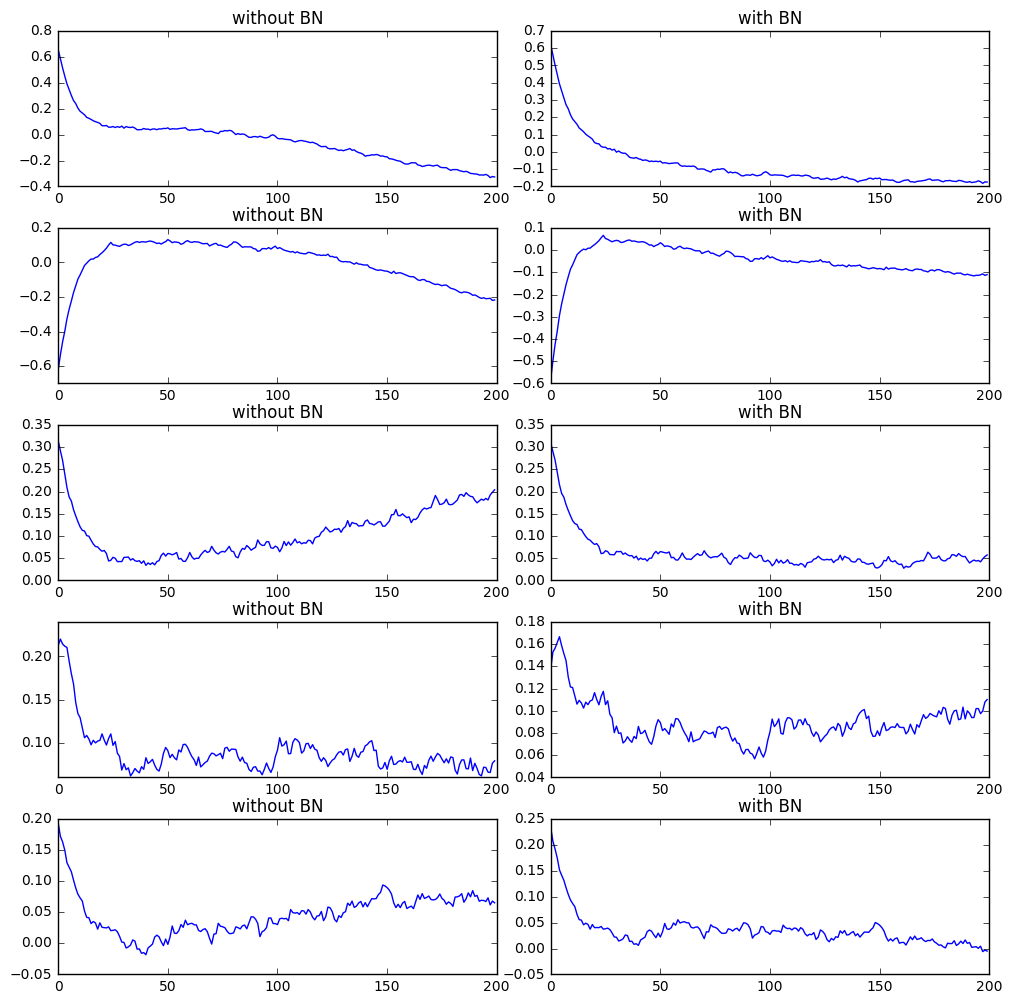

In [15]:
final_layers, final_layers_bn = np.array(final_layers), np.array(final_layers_bn)
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
plt.tight_layout()

for i, ax in enumerate(axes):
    ax[0].plot(final_layers[:, i])
    ax[0].set_title("without BN")
    ax[1].plot(final_layers_bn[:, i])
    ax[1].set_title("with BN")
    

### Conclusion from the above graph
1. Batch normalization helps in training faster. 
2. Batch normalization makes the training more robust to initialization.
3. Batch normalization can handle higher learning rate.
4. Batch normalization reduces the requirement for the dropout.

### Batch Normalization in testing

During testing, we need an estimate of population mean and population variace to compute the batch normalization. We keep an estimate of running mean and running variance during training and use it during testing.

In [16]:
# this is a simpler version of Tensorflow's 'official' version. See:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L102
def batch_norm_wrapper(inputs, is_training, decay = 0.999):

    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, eps)
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, eps)

In [17]:
def build_graph(is_training):
    # Placeholders
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])

    # Layer 1
    W1 = tf.Variable(w1)
    z1 = tf.matmul(x,W1)
    bn1 = batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.sigmoid(bn1)

    #Layer 2
    W2 = tf.Variable(w2)
    z2 = tf.matmul(l1,W2)
    bn2 = batch_norm_wrapper(z2, is_training)
    l2 = tf.nn.sigmoid(bn2)

    # Softmax
    W3 = tf.Variable(w3)
    b3 = tf.Variable(tf.zeros([10]))
    y  = tf.nn.softmax(tf.matmul(l2, W3))

    # Loss, Optimizer and Predictions
    cross_entropy = -tf.reduce_mean(y_*tf.log(y))

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

    return (x, y_), train_step, accuracy, y, tf.train.Saver()

In [18]:
#Build training graph, train and save the trained model

sess.close()
tf.reset_default_graph()
(x, y_), train_step, accuracy, _, saver = build_graph(is_training=True)

acc = []
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(10000):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 50 is 0:
            res = sess.run([accuracy],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc.append(res[0])
            print(".",end="")
    saved_model = saver.save(sess, 'temp-bn-save')

print("Final accuracy:", acc[-1])

........................................................................................................................................................................................................Final accuracy: 0.8768


In [19]:
tf.reset_default_graph()
(x, y_), _, accuracy, y, saver = build_graph(is_training=False)

predictions = []
correct = 0
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, saved_model)
    for i in range(100):
        pred, corr = sess.run([tf.arg_max(y,1), accuracy],
                             feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
        correct += corr
        predictions.append(pred[0])
print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/100)

PREDICTIONS: [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 3, 9, 7, 6, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 1, 1, 1, 7, 4, 1, 3, 5, 3, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 2, 7, 9, 6, 4, 3, 0, 7, 0, 2, 8, 1, 7, 3, 7, 9, 7, 9, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4, 1, 1, 6, 9]
ACCURACY: 0.86
